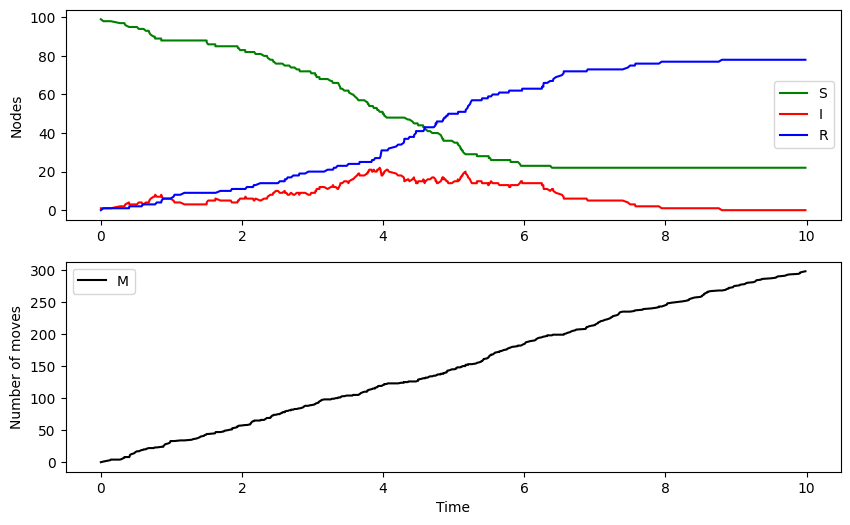

In [218]:
# Gerando o Grafo
import networkx as nx, numpy as np, random as rd


#G = nx.Graph()
#G.add_nodes_from((0,1,2,3,4))
#G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,0),(0,2),(0,3),(1,3),(1,4),(2,4)])

G = nx.random_regular_graph(3,100)

# Criando lista de adjacencia
dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
adj_mtz = {}
for i in sordic:
    adj_mtz.update({i:dic[i]})

# Taxa de infecção, recuperação e mobilidade
τ = 2.0
γ = 1.0
m = 0.3
tmax = 10


# Suscetíveis iniciais
susceptibles_nodes = list(adj_mtz)

# Infectados iniciais
n = 1
initial_infections = []
while len(initial_infections) < n:
    r = rd.choice(list(susceptibles_nodes))
    initial_infections.append(r)
    susceptibles_nodes.pop(susceptibles_nodes.index(r))
infected_nodes = initial_infections

# Recuperados iniciais
n = 1
recovered_nodes = []
while len(recovered_nodes) < n:
    r = rd.choice(list(susceptibles_nodes))
    recovered_nodes.append(r)
    susceptibles_nodes.pop(susceptibles_nodes.index(r))

# Vazios iniciais
n = 1
empty_nodes = []
while len(empty_nodes) < n:
    r = rd.choice(list(susceptibles_nodes))
    empty_nodes.append(r)
    susceptibles_nodes.pop(susceptibles_nodes.index(r))

# Vizinhos vazios
at_mov_nodes = []
for n in empty_nodes:
    viz = list(adj_mtz[n])
    for v in viz:
        if v not in empty_nodes:
            at_mov_nodes.append(v)
at_mov_nodes = list(set(at_mov_nodes))

# Taxa de mobilidade
mobility_rate = np.zeros(len(adj_mtz))
for n in at_mov_nodes:
    viz = list(adj_mtz[n])
    n_viz = 0
    for vv in viz:
        if vv in empty_nodes:
            n_viz += 1
    mobility_rate[n] = m*n_viz

# Vizinhos infectados
at_risk_nodes = []
for n in infected_nodes:
    viz = list(adj_mtz[n])
    for v in viz:
        if v in susceptibles_nodes:
            at_risk_nodes.append(v)
at_risk_nodes = list(set(at_risk_nodes))

# Taxa de infecção
infection_rate = np.zeros(len(adj_mtz))
for n in at_risk_nodes:
    viz = list(adj_mtz[n])
    n_viz = 0
    for vv in viz:
        if vv in infected_nodes:
            n_viz += 1
    infection_rate[n] = τ*n_viz

# Plot
times = [0]
S = [len(adj_mtz) - len(initial_infections)]
I = [len(initial_infections)]
R = [0]

# Definindo as taxas de infecção total e recuperação total
total_infection_rate = np.sum(infection_rate)
total_recovery_rate = γ*len(infected_nodes)
total_mobility_rate = np.sum(mobility_rate) # Taxa total de mobilidade
total_rate = total_infection_rate + total_recovery_rate + total_mobility_rate


# Tempo será selecionado desta forma
time = -np.log(rd.random())/total_rate


# Armazenando os nós recuperados e quantos que se moveram para fins de plot.
moved = [0]
mob_count = 0


#print(f'Nós suscetíveis: {susceptibles_nodes}')
#print(f'Nós infectados: {infected_nodes}')
#print(f'Nós recuperados: {recovered_nodes}')
#print(f'Nós vazios: {empty_nodes}')
#print(at_risk_nodes)
#print(infection_rate)


# Início da simulação
while time < tmax:

    r = rd.uniform(0,1)
    r_rec = total_recovery_rate/total_rate
    r_inf = total_infection_rate/total_rate
    r_mob = total_mobility_rate/total_rate
    
    #print('at_risk_nodes', at_risk_nodes)
    #print('infection_rate', infection_rate)    

    # Recuperação
    if r < r_rec:
        
        u = rd.choice(infected_nodes)

        infected_nodes.pop(infected_nodes.index(u))
        recovered_nodes.append(u)

        uviz = list(adj_mtz[u])
        for v in uviz:
            if v in at_risk_nodes:
                infection_rate[v] -= τ
                
                #print('v: ',v,' infection_rate A : ',infection_rate[v])
                
                if infection_rate[v] == 0:
                    at_risk_nodes.pop(at_risk_nodes.index(v))
                
        #print(f'\nRecuperação.')
        #print(f'{u} se recuperou.')
        #print(f'Taxa de infecção:{infection_rate}.')
        #print(f'Nó suscetível: ',susceptibles_nodes)

    # Infecção
    elif r_rec < r <= (r_rec + r_inf):
        
        #print('I')
        #print('r_inf', r_inf)
        #print('r_rec', r_rec)
        #print('r_mob', r_mob)



        p = infection_rate/total_infection_rate
        p_list_inf = []
        for i in at_risk_nodes:
            p_list_inf.append(p[i])
            
        #print('p_list_inf',p_list_inf)
        #print('at_risk_nodes',at_risk_nodes)
        #print(len(infected_nodes))
        
        u = rd.choices(at_risk_nodes, weights=p_list_inf)[0]
        
        susceptibles_nodes.pop(susceptibles_nodes.index(u))
        at_risk_nodes.pop(at_risk_nodes.index(u))
        infection_rate[u] = 0
        #print('v: ',u,' infection_rate: ',infection_rate[u])

        infected_nodes.append(u)

        uviz = list(adj_mtz[u])
        for v in uviz:
            if v in susceptibles_nodes:
                infection_rate[v] += τ
                
                #print('v: ',v,' infection_rate B : ',infection_rate[v])
                
                if v not in at_risk_nodes:
                    at_risk_nodes.append(v)
        at_risk_nodes = list(set(at_risk_nodes))



        #print('\nInfecção')
        #print(f'{u} se infecta')
        #print(f'Taxa de infecção: {infection_rate}')
        #print(f'Nós infectados: {infected_nodes}')
        #print(f'Nó suscetível: ',susceptibles_nodes)

    # Mobilidade
    elif (r_rec + r_inf) < r <= (r_rec + r_inf + r_mob):
        
        mob_count += 1
        
        # Quem vai se mover
        p = mobility_rate/total_mobility_rate
        p_list = []
        for i in at_mov_nodes:
            p_list.append(p[i])
        u = rd.choices(at_mov_nodes, weights=p_list)[0]

        # Para onde vai se mover
        uviz = list(adj_mtz[u])
        emp_list = []
        for i in uviz:
            if i in empty_nodes:
                emp_list.append(i)
        e = rd.choices(emp_list)[0]
        
        empty_nodes.pop(empty_nodes.index(e))
        empty_nodes.append(u)
        
        # u
        
        # Atualizando taxa de mobilidade dos viznhos de u
        u_viz = list(adj_mtz[u])
        for v in u_viz:
            if v not in empty_nodes:
                at_mov_nodes.append(v)
                mobility_rate[v] += m    
        
        # e
        
        # Atualizando taxa de mobilidade dos vizinhos de e
        e_viz = list(adj_mtz[e])
        for v in e_viz:
            if v in at_mov_nodes:
                at_mov_nodes.pop(at_mov_nodes.index(v))
                mobility_rate[v] -= m
                
        # Se u é infectado
        if u in infected_nodes:
            u_compartment = 'I'
        
            # Aumentando taxa de infecção após o movimento
            eviz = list(adj_mtz[e])
            for v in eviz:
                if v in susceptibles_nodes:
                    infection_rate[v] += τ
                    
                    #print('v: ',v,' infection_rate C : ',infection_rate[v])

                    if v not in at_risk_nodes:
                        at_risk_nodes.append(v)
            at_risk_nodes = list(set(at_risk_nodes))

            # Diminuindo a taxa de infecção no novo local vazio
            uviz = list(adj_mtz[u])
            for v in uviz:
                if v in at_risk_nodes:
                    infection_rate[v] -= τ
                    
                    #print('v: ',v,' infection_rate D : ',infection_rate[v])

                    if infection_rate[v] == 0:
                        at_risk_nodes.pop(at_risk_nodes.index(v))
            
            infected_nodes.pop(infected_nodes.index(u))
            infected_nodes.append(e)

        # Se u é suscetível
        elif u in susceptibles_nodes:
            
            u_compartment = 'S'
            
            # Atualizar lista de suscetíveis
            susceptibles_nodes.pop(susceptibles_nodes.index(u))  
            susceptibles_nodes.append(e)

            # at_risk_nodes            
            if u in at_risk_nodes:
                at_risk_nodes.pop(at_risk_nodes.index(u))
                infection_rate[u] = 0
            
            # Atualizar taxa de infecção
            eviz = list(adj_mtz[e])
            for v in eviz:
                if v in infected_nodes:
                    infection_rate[e] += τ
                    
                    #print('v: ',v,' infection_rate E : ',infection_rate[v])
                    
                    if v not in at_risk_nodes:
                        at_risk_nodes.append(e)
            at_risk_nodes = list(set(at_risk_nodes))

        # Se u é um recuperado
        elif u in recovered_nodes:
            
            # Removo u da lista de recuperados e adiciono 'e' nesta lista
            recovered_nodes.pop(recovered_nodes.index(u))
            recovered_nodes.append(e)
            
            u_compartment = 'R'

        #print('\nMovimentação')
        #print(f'Compartimento: {u_compartment}')
        #print(f'{u} ocupado troca com {e} vazio')
        #print(f'Nó suscetível: ',susceptibles_nodes)


    # Armazenando dados para fins de plot
    S.append(len(adj_mtz) - len(infected_nodes) - len(recovered_nodes))
    
    I.append(len(infected_nodes))
    
    R.append(len(recovered_nodes))
    
    moved.append(mob_count)
    
    times.append(time)
    
    # Atualizando as taxas e o tempo
    total_recovery_rate = γ*len(infected_nodes)
    total_infection_rate = np.sum(infection_rate)
    total_mobility_rate = m*(len(adj_mtz)) # Taxa total de mobilidade
    total_rate = total_infection_rate + total_recovery_rate + total_mobility_rate
    
    time = time - np.log(rd.random())/total_rate

import matplotlib.pyplot as plt

Fig, ax = plt.subplots(nrows=2, figsize=(10,6))
ax[0].plot(times, S, label='S', color='green')
ax[0].plot(times, I, label='I', color='red')
ax[0].plot(times, R, label='R', color='blue')
ax[1].plot(times, moved, label='M', color='k')

ax[0].set_ylabel('Nodes')
ax[1].set_ylabel('Number of moves')
ax[1].set_xlabel('Time')
ax[0].legend()
ax[1].legend()

In [22]:
lista = [1,2,3,4,5,6]
r = [4]
for i in r:
    lista.pop(lista.index(i))
lista

[1, 2, 3, 5, 6]